In [1]:
# Import module
import os
import clip
import glob
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [42]:
import os, glob, re

def all_img_path(data_dir='dataset/seg'):
    all_img_path = {}
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        img_list = sorted(
            glob.glob(os.path.join(folder_path, '*.jpg')),
            key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group())
        )
        img_list = [p.replace('\\', '/') for p in img_list]
        all_img_path[folder] = img_list
    return all_img_path


In [43]:
all_img_path = all_img_path()
print(all_img_path)

{'buildings': ['dataset/seg/buildings/0.jpg', 'dataset/seg/buildings/4.jpg', 'dataset/seg/buildings/47.jpg', 'dataset/seg/buildings/53.jpg', 'dataset/seg/buildings/55.jpg', 'dataset/seg/buildings/66.jpg', 'dataset/seg/buildings/92.jpg', 'dataset/seg/buildings/96.jpg', 'dataset/seg/buildings/112.jpg', 'dataset/seg/buildings/125.jpg', 'dataset/seg/buildings/137.jpg', 'dataset/seg/buildings/139.jpg', 'dataset/seg/buildings/142.jpg', 'dataset/seg/buildings/146.jpg', 'dataset/seg/buildings/154.jpg', 'dataset/seg/buildings/157.jpg', 'dataset/seg/buildings/158.jpg', 'dataset/seg/buildings/188.jpg', 'dataset/seg/buildings/191.jpg', 'dataset/seg/buildings/218.jpg', 'dataset/seg/buildings/230.jpg', 'dataset/seg/buildings/235.jpg', 'dataset/seg/buildings/246.jpg', 'dataset/seg/buildings/256.jpg', 'dataset/seg/buildings/263.jpg', 'dataset/seg/buildings/265.jpg', 'dataset/seg/buildings/266.jpg', 'dataset/seg/buildings/286.jpg', 'dataset/seg/buildings/292.jpg', 'dataset/seg/buildings/304.jpg', 'data

In [44]:
bs = 20
save_dir = './CLIP_features'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for label, img_paths in all_img_path.items():
    all_features = []
    for i in tqdm(range(0, len(img_paths), bs)):
        batch_imgs = [preprocess(Image.open(p).convert("RGB")).unsqueeze(0) for p in img_paths[i:i+bs]]
        batch_imgs = torch.cat(batch_imgs).to(device)

        with torch.no_grad():
            image_features = model.encode_image(batch_imgs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        for b in range(image_features.shape[0]):
            all_features.append(image_features[b].cpu().numpy().astype(np.float32).flatten())

    np.save(os.path.join(save_dir, f'{label}_features.npy'), np.array(all_features))

100%|██████████| 120/120 [00:07<00:00, 15.35it/s]


In [45]:
import faiss
feature_shape = 512
feature_dir = './CLIP_features'
index = faiss.IndexFlatL2(feature_shape)

for feature_file in os.listdir(feature_dir):
    features = np.load(os.path.join(feature_dir, feature_file))
    for feat in features:
        index.add(feat.astype(np.float32).reshape(1, -1))
faiss.write_index(index, 'faiss_clip.bin')

# build mapping id2img

{'buildings': ['dataset/seg/buildings/0.jpg', 'dataset/seg/buildings/4.jpg', 'dataset/seg/buildings/47.jpg', 'dataset/seg/buildings/53.jpg', 'dataset/seg/buildings/55.jpg', 'dataset/seg/buildings/66.jpg', 'dataset/seg/buildings/92.jpg', 'dataset/seg/buildings/96.jpg', 'dataset/seg/buildings/112.jpg', 'dataset/seg/buildings/125.jpg', 'dataset/seg/buildings/137.jpg', 'dataset/seg/buildings/139.jpg', 'dataset/seg/buildings/142.jpg', 'dataset/seg/buildings/146.jpg', 'dataset/seg/buildings/154.jpg', 'dataset/seg/buildings/157.jpg', 'dataset/seg/buildings/158.jpg', 'dataset/seg/buildings/188.jpg', 'dataset/seg/buildings/191.jpg', 'dataset/seg/buildings/218.jpg', 'dataset/seg/buildings/230.jpg', 'dataset/seg/buildings/235.jpg', 'dataset/seg/buildings/246.jpg', 'dataset/seg/buildings/256.jpg', 'dataset/seg/buildings/263.jpg', 'dataset/seg/buildings/265.jpg', 'dataset/seg/buildings/266.jpg', 'dataset/seg/buildings/286.jpg', 'dataset/seg/buildings/292.jpg', 'dataset/seg/buildings/304.jpg', 'data

In [35]:
import json

# Tạo file id2img.json nếu chưa có
id2img_path = 'id2img.json'
if not os.path.exists(id2img_path):
    id2img = {}
    cnt = 0
    for folder in all_img_path:
        for img_path in all_img_path[folder]:
            id2img[str(cnt)] = img_path
            cnt += 1
    with open(id2img_path, 'w', encoding='utf-8') as f:
        json.dump(id2img, f, ensure_ascii=False, indent=2)



# Test Clip

In [46]:
class myFaiss:
    def __init__(self, bin_clip_file = "faiss_clip.bin", feature_shape=512):
        self.index_clip = self.load_bin_file(bin_clip_file)
        self.clip_model = clip.load("ViT-B/32", device=device)[0]
        self.__device = "cuda" if torch.cuda.is_available() else "cpu"

    def load_bin_file(self, bin_file):
        return faiss.read_index(bin_file)
    def image_search(self, img, top_k=5):
        img = preprocess(img).unsqueeze(0).to(self.__device)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(img)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.cpu().numpy().astype(np.float32)
        scores , idx_image = self.index_clip.search(image_features, top_k)
        idx_image = idx_image.flatten()
        scores = scores.flatten()
        return scores , idx_image
   


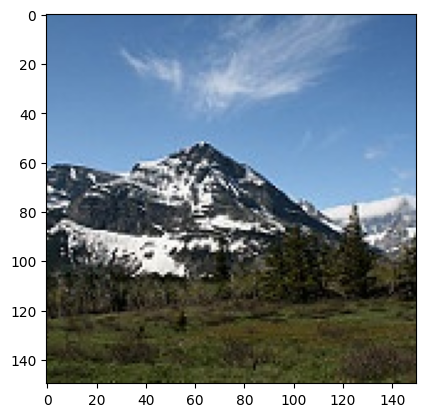

In [47]:
img  = Image.open('dataset/seg_test/mountain/20107.jpg').convert("RGB")
plt.imshow(img)

In [48]:
import faiss
faiss = myFaiss()
img  = Image.open('dataset/seg_test/mountain/20107.jpg').convert("RGB")
scores, idxs = faiss.image_search(img, top_k=5)
print("Scores: ", scores)
import os
print("Index: ", idxs)
print("Image paths: ")


Scores:  [0.08868025 0.10575123 0.10822791 0.11989386 0.12509558]
Index:  [7476 9129 7792 7361 8466]
Image paths: 


{'0': 'dataset/seg/buildings/0.jpg', '1': 'dataset/seg/buildings/4.jpg', '2': 'dataset/seg/buildings/47.jpg', '3': 'dataset/seg/buildings/53.jpg', '4': 'dataset/seg/buildings/55.jpg', '5': 'dataset/seg/buildings/66.jpg', '6': 'dataset/seg/buildings/92.jpg', '7': 'dataset/seg/buildings/96.jpg', '8': 'dataset/seg/buildings/112.jpg', '9': 'dataset/seg/buildings/125.jpg', '10': 'dataset/seg/buildings/137.jpg', '11': 'dataset/seg/buildings/139.jpg', '12': 'dataset/seg/buildings/142.jpg', '13': 'dataset/seg/buildings/146.jpg', '14': 'dataset/seg/buildings/154.jpg', '15': 'dataset/seg/buildings/157.jpg', '16': 'dataset/seg/buildings/158.jpg', '17': 'dataset/seg/buildings/188.jpg', '18': 'dataset/seg/buildings/191.jpg', '19': 'dataset/seg/buildings/218.jpg', '20': 'dataset/seg/buildings/230.jpg', '21': 'dataset/seg/buildings/235.jpg', '22': 'dataset/seg/buildings/246.jpg', '23': 'dataset/seg/buildings/256.jpg', '24': 'dataset/seg/buildings/263.jpg', '25': 'dataset/seg/buildings/265.jpg', '26':

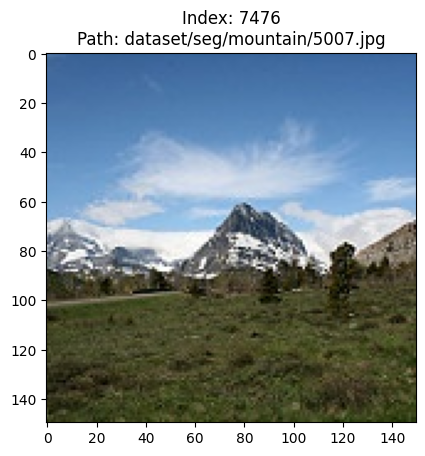

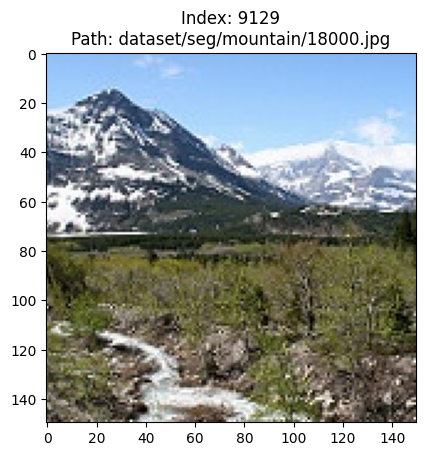

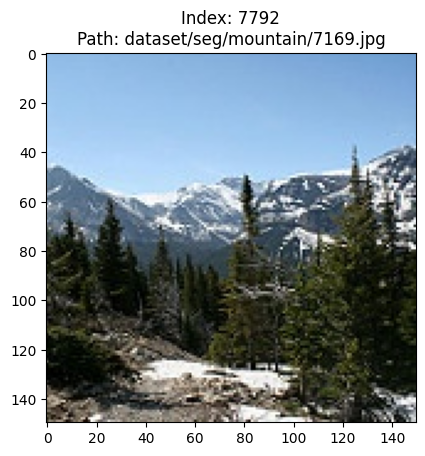

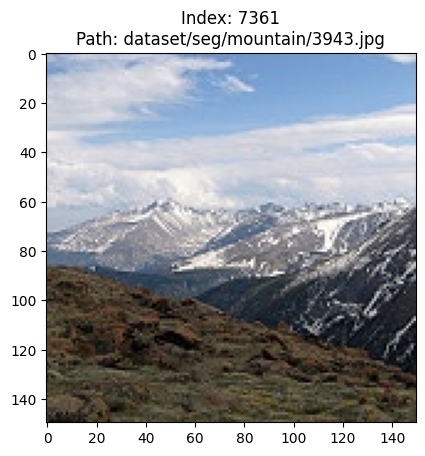

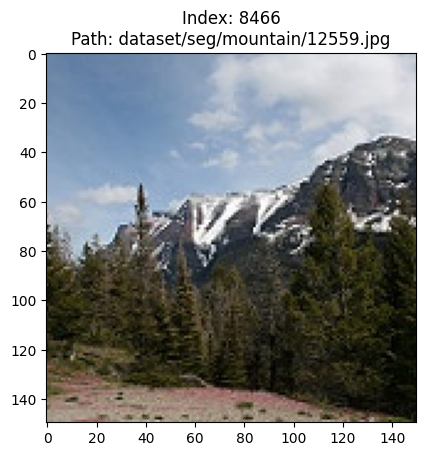

In [50]:
import json
id2img = json.load(open('id2img.json', 'r'))
print(id2img)
for idx in idxs:
    idx= str(idx)
    img_path = id2img[idx]
    plt.title(f"Index: {idx}\nPath: {img_path}")
    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.show()
      
     